In [3]:
# Vasicek Model - a special case of Hull White Model
# r_t = r_0exp(-alpha*t) + sigmaexp(-alpha*t)Integral[0:t][exp(-alpha*s) dWs]
# Given we know r_t1; r_t2 ~ N(r_t1*exp(-alpha(t2-t1)) + b(1-exp(-alpha(t2-t1))), sigma**2/2*alpha * (1-exp(-2*alpha*(t2-t1))))
# Above is due to independant increments of Brownina motion
# Advantage  - has closed form solution
# Disadvantage Vasicek model -short rates can become negative

In [4]:
# Bond price under close form Vasicek Model is 
# B(t,T)  = exp(-A(t,T) + D(t,T))
# A(t,T)  = 1-exp(-alpha*(T-t))
# D(t,T)  = (b- sigma**2/2*alpha**2) [A(t,T) - (T-t)] - sigma**2*A(t,T)**2/4*alpha

In [146]:
# Import modules 
import math
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [6]:
# Market, option,interest rate information and dynamics
r_0   = 0.05   # initial r(0) starting/known interest rate 
alpha = 0.2    # rate at which short rate tends toward long-term average
b     = 0.08   # long-term average short rate
sigma = 0.025  # volatility of short rate

# Monte Carlo Simulation dynamics
num_years       = 10 
num_simulations = 100000
t               = np.array(range(0,num_years+1))

In [109]:
# Functions for modelling
def vasicek_mean(r_t1,t1,t2):
    return r_t1*np.exp(-alpha*(t2-t1)) + b*(1-np.exp(-alpha*(t2-t1)))

def vasicek_var(t1,t2):
    return (sigma**2)*(1-np.exp(-2*alpha*(t2-t1)))/(2*alpha)

In [112]:
#1. Analytical bond price functions based off closed form Vasicek model
def A_t_T(t1,t2):
    return (1 - np.exp(-alpha*(t2-t1)))/alpha

def D_t_T(t1,t2):
    val1 = (sigma**2/(2*alpha**2)-b)*(-A_t_T(t1,t2)+ t2-t1)
    val2 = sigma**2*A_t_T(t1,t2)**2/(4*alpha)
    return val1-val2
    
def bond_price(r_t,t,T):
    return np.exp(-A_t_T(t,T)*r_t + D_t_T(t,T))

closed_form_price = bond_price(0.05,0,t)
closed_form_price

array([1.        , 0.94864587, 0.89590226, 0.84325592, 0.79169223,
       0.74184433, 0.69410022, 0.64867847, 0.60568138, 0.5651321 ,
       0.52700054])

In [113]:
# Estimating bond price by jointly simulating short rate r_t and value Integral[0,t][r_s ds] = Y_t
# Since r_t is Gaussian and Y_t is Gaussian r_t and Y_t have joint Guassian distribution
# We simulate the above using the value of their means, variances and correlation

In [114]:
# Functions for means, variances and correlations
# Y_mean_t2 calcutes mean Y_t2 given Y_t1
# Y_var_t2 calculates the variance of Y_t2 from time t1<t2
# rY_var   calculates the covariance between Y_t2 and r_t2
# rY_rho   calculates the correlation from above covariance

def Y_mean_t2(Y_t1, r_t1, t1, t2):   #Y_t2 given Y_t1
    return Y_t1 + (t2-t1)*b + (r_t1-b)*A_t_T(t1,t2)

def Y_var_t2(t1,t2):   
    return sigma**2 *(t2-t1 - A_t_T(t1,t2) - alpha*A_t_T(t1,t2)**2/2)/(alpha**2)

def rY_var(t1,t2):
    return sigma**2*(A_t_T(t1,t2)**2)/2

def rY_rho(t1,t2):
    return rY_var(t1,t2)/np.sqrt(vasicek_var(t1,t2)*Y_var_t2(t1,t2))

In [116]:
#2. Simlulation using Monte Carlo with Intergral[0:t][r_s ds]
# Implementation of simulations
# We jointly simulate r_t and Intergral[0:t][r_s ds] taking into accunt their variances, covariances

Y_0 = 0
np.random.seed(0)
Z1   = norm.rvs(size = [num_simulations,num_years])
Z2   = norm.rvs(size = [num_simulations,num_years])
r_sim = np.zeros([num_simulations, num_years+1])   # various simulation paths for r_t
Y_sim = np.zeros([num_simulations, num_years+1])   # various simulation paths for Y_t

r_sim[:,0] = r_0   
Y_sim[:,0] = Y_0

correlations     = rY_rho(t[0:-1],t[1:])   #various correlations at t_i+1, t_i
Z2               =  correlations*Z1 + np.sqrt(1-correlations**2)*Z2   #creating correlated standard normals

for i in range(num_years):
    r_sim[:,i+1] = vasicek_mean(r_sim[:,i], t[i],t[i+1]) + np.sqrt(vasicek_var(t[i],t[i+1]))*Z1[:,i]
    Y_sim[:,i+1] = Y_mean_t2(Y_sim[:,i],r_sim[:,i],t[i],t[i+1]) + np.sqrt(Y_var_t2(t[i],t[i+1]))*Z2[:,i]
    
ZCB_prices = np.mean(np.exp(-Y_sim), axis = 0)
ZCB_prices

array([1.        , 0.94867239, 0.89587172, 0.84314185, 0.79153931,
       0.74168785, 0.69395339, 0.64854705, 0.60556234, 0.56496465,
       0.52671645])

In [136]:
#.3 Simulating using Quadrature by estimating value Intergral[0:t][r_s ds] as Sum[0;n-1][r_t_i * delta_i]
r_mat_1 = np.cumsum(r_sim[:,0:-1], axis = 1)*(t[1:]-t[0:-1])

ZCB_prices_quad1 = np.ones(num_years+1)
ZCB_prices_quad1[1:] = np.mean(np.exp(-r_mat_1), axis = 0)
ZCB_prices_quad1

array([1.        , 0.95122942, 0.90016356, 0.84847558, 0.79747038,
       0.74790303, 0.70027499, 0.65479121, 0.61163039, 0.57087667,
       0.53243707])

In [137]:
#.4 Simulating using Quadrature by estimating value Intergral[0:t][r_s ds] as Sum[0;n-1][(r_t_i+r_t_i+1)/2 * delta_i]
#r_mat_2 = np.cumsum(r_sim[:0,0:-1] + r_sim[:,1:], axis = 1) /2 *(t[1:]-t[0:-1])
r_mat_2 = np.cumsum(r_sim[:,0:-1], axis = 1)*(t[1:]-t[0:-1])

ZCB_prices_quad2 = np.ones(num_years+1)
ZCB_prices_quad2[1:] = np.mean(np.exp(-r_mat_1), axis = 0)
ZCB_prices_quad2

array([1.        , 0.95122942, 0.90016356, 0.84847558, 0.79747038,
       0.74790303, 0.70027499, 0.65479121, 0.61163039, 0.57087667,
       0.53243707])

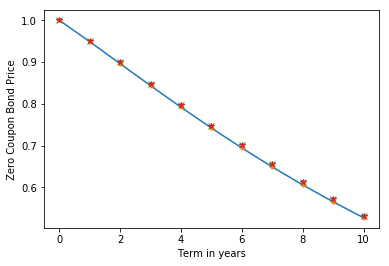

In [139]:
# Plot of results 
plt.plot(t,closed_form_price)
plt.plot(t,ZCB_prices,'.')
plt.plot(t,ZCB_prices_quad1,'x')
plt.plot(t,ZCB_prices_quad2,'*')
plt.xlabel("Term in years")
plt.ylabel("Zero Coupon Bond Price")
plt.show()


In [144]:
# Determining bond yields 
# B(0,t) = exp(-y_t*t) where y_t becomes the implied bond yield
# y_t = -ln(B(0,t))/t

bond_yield_analytic = -np.log(closed_form_price[1:])/t[1:] #bond yield based on analytic prices
bond_yield_direct   = -np.log(ZCB_prices[1:])/t[1:] # bond yield based on ZCB priced using r_t and Y_t correlated
bond_yield_quad1    = -np.log(ZCB_prices_quad1[1:])/t[1:] #bond yield based on analytic prices
bond_yield_quad2    = -np.log(ZCB_prices_quad2[1:])/t[1:] # bond yield based on ZCB priced using r_t and Y_t correlated


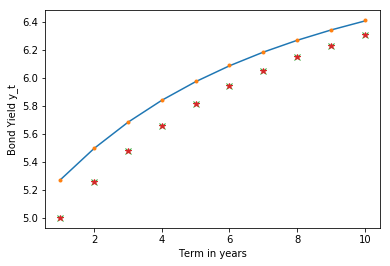

In [145]:
# Plot of bond yeilds
plt.plot(t[1:],bond_yield_analytic*100)
plt.plot(t[1:],bond_yield_direct*100,'.')
plt.plot(t[1:],bond_yield_quad1*100,'x')
plt.plot(t[1:],bond_yield_quad2*100,'*')
plt.xlabel("Term in years")
plt.ylabel("Bond Yield y_t")
plt.show()